# Modélisation du transport des individus - MTH3302

### 22 avril 2019
Ce travail est présenté à Jonathan Jalbert par Benjamin Beaudry, Marilou Farmer, Sébastien Labine, Antoine Lamontage et Mikaël LeBlanc.


## Table des matières
- [Introduction](#1.-introduction)
- [Analyse exploratoire](#2.-analyse-exploratoire)
- [Maximum de vraisemblance](#3.-maximum-vraisemblance)
- [Classification bayésienne naïve](#4.-classification-bayesienne-naive)


# 1. Introduction

Afin de construire un modèle prédictif des modes de transport des individus de la grande région de Montréal, nous avons effectué un travail d'analyse en appliquant plusieurs notions vues dans le cadre du cours. Ce notebook détaille le cheminement parcouru du départ jusqu'à la fin. Tout d'abord, nous avons débuté par une analyse exploratoire des données afin de trouver des liens entre certaines variables explicatives et les modes de transports. Ensuite, à l'aide du maximum de vraisemblance, nous avons trouvé les paramètres des distributions appropriées de chaque mode de transport pour chaque variable explicative. Finalement, nous avons utilisé la classification bayésienne naïve pour obtenir un modèle prédictif.
<br><br>
Tout au long du projet, nous avons réalisé de nombreuses expériences et de nombreux tests qui n'ont parfois pas eu les résultats escomptés. Dans ce rapport, nous avons décidé de présenter évidemment les tentatives qui ont apportés des résultats favorables à notre modèle, mais aussi quelques expérimentations que nous jugeons intéressantes malgré leur inutilité dans ce travail.

## 1.1 Initialisation et nettoyage des données

Le code suivant est tiré du TD 9.

In [1]:
# import
using CSV, DataFrames, Gadfly, Distributions, StatsBase

# Chargement des données
train = CSV.read("ODtrain.csv")
first(train,5)

n = size(train,1)
p = size(train,2)

# Se débarrasser du type complexe permettant les valeurs manquantes.
dropmissing!(train, disallowmissing=true)
first(train,5)

# Transformation de la variable de mode de transport en une catégorielle avec de beaux noms (pour les graphiques)
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

d = Array{String}(undef,n)

for i=1:length(str_mode)
   
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
    
end

train[:D_Mode_str] = d

categorical!(train, :D_Mode_str)

first(train,5)

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/BenjaminBeaudry/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


5×20 DataFrame. Omitted printing of 13 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

## 2. Analyse exploratoire

L'analyse exploratoire permet de découvrir des informations utiles sur les données et de guider les décisions. Les différentes variables explicatives analysées ici utilisent la fonction suivante donnée dans le TD9 pour représenter les données sur un histogramme. 

In [2]:
#= fonction permettant d'extraire la fréquence relative de chaque mode en fonction des 
classes «edges» de la variable explicative =#

function histnorm(train::DataFrame, edges::AbstractVector, varname::Symbol)

    center = (edges[1:end-1]+edges[2:end])/2

    c = Array{Float64}(undef,5,length(center))
    
    m = unique(train[:D_Mode_str])
    

    for i=1:length(m)
        ind = train[:D_Mode_str] .== m[i]
        x = train[ind, varname]

        h = fit(Histogram,x, edges)

        c[i,:] = h.weights

    end

    nᵢ = vec(sum(c, dims=1))

    df = DataFrame(Center = center)

    for i=1:5
        df[Symbol(m[i])] = c[i,:] ./ nᵢ
    end

    df = melt(df, :Center)

    rename!(df, :Center => varname)
    rename!(df, :value => :proportion)
    rename!(df, :variable => :D_Mode_str)

    return df
    
end

histnorm (generic function with 1 method)

### P_Permis

La variable P_Permis de l'ensemble de données est une catégorielle contenant 5 catégories (1: Oui, 2: Non, 3: Ne sait pas, 4: Refus, 5: Non applicable(<16 ans)). Voici la proportion de fréquence des modes de transports en fonction de la possession d'un permis de conduire.

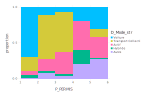

In [3]:
df = histnorm(train,0:1:8,:P_PERMIS)
plot(df, x = :P_PERMIS, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1, xmin=1, xmax=6))

### M_dist_centre

La variable M_dist_centre décrit la distance en km du ménage au centre-ville de Montréal. L'hypothèse que nous posions quant à cette variable est que plus une personne habite proche du centre ville, moins qu'il voyagera avec sa voiture. Selon cette hypothèse, les probabilités qu'on voyage en transport en commun ou en transport actif augmente donc en fonction de la proximité au centre-ville. De plus, nous expliquerions une baisse de l'utilisation de la voiture pour les personnes y vivant pour deux raisons principales. D'une part, une majorité des personnes vivants au centre-ville y travaillent également et d'autre part, les personnes au centre-ville ont moins l'intention de prendre leur voiture en raison de la difficulté d'y voyager et de la facilité accrue de l'accès aux transports en commun et des commerces.

Cette variable est continue.

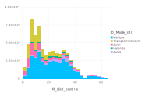

In [4]:
plot(train, x=:M_dist_centre, color=:D_Mode_str,
     Geom.histogram(bincount=30), Coord.cartesian(xmin=0, xmax = 65))

### P_AGE

Avec cette variable, nous confirmons notre hypothèse selon laquelle les personnes plus jeunes utilisent plus le transport en commun que les personnes plus agées. Nous basons cette hypothèse sur nos expériences personnelles desquelles découle la perception que les personnes de notre génération ont plus tendance à choisir les transports en commun que la voiture lorsque possible.

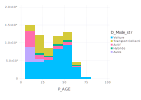

In [5]:
plot(train, x=:P_AGE, color=:D_Mode_str, Geom.histogram(bincount=8))

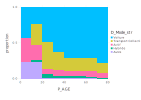

In [6]:
df = histnorm(train,0:10:80,:P_AGE)
plot(df, x = :P_AGE, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

Comme nous le pensions, ce graphique démontre que les personnes non dépendantes de leurs parents pour leurs déplacements de 25 ans et moins  ont moins tendance à choisir le véhicule que les personnes de la génération d'avant.

### D_HREDE

L'heure de départ (ramenée au format 24h) est une variable qui nous semble riche en informations comme nous croyons fortement qu'un déplacement dépend de l'heure à laquelle il a lieu. En effet, les déplacements aux heures de pointe pousseront peut-être une personne à choisir les transports en commun si accessibles plutôt que sa voiture alors qu'un voyage au petites heures de la nuit où les services de transport en commun sont diminués et les routes libérées du traffic encourageront un sujet à opter pour la voiture.

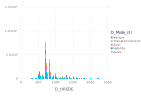

In [9]:
# modulo 2400 pour que les heures soient en format 24h
train[:D_HREDE] .%= 2400; 
plot(train, x=:D_HREDE, color=:D_Mode_str, Geom.histogram)

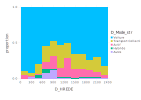

In [10]:
df = histnorm(train,0:200:2400,:D_HREDE)
plot(df, x = :D_HREDE, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1, xmax=2400))

### M_DOMSM

Le secteur municipal du ménage est décrit par la variable M_DOMSM. Dans un premier temps, nous avons décidé de simplement afficher l'histogramme du mode de transport en fonction des secteur municipaux.

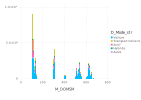

In [12]:
plot(train, x=:M_DOMSM, color=:D_Mode_str, Geom.histogram(bincount=113))

Il apparaît évident ici que l'information véhiculée par cette variable sous sa forme brute n'est pas directement utilisable et de faible valeur. Toutefois, dans un deuxième temps, nous avons utilisé les résultats de cette variable avec les régions et leurs secteurs municipaux disponibles sur Moodle pour créer une nouvelle variable M_DOMSM_G qui est une catégorielle des différentes régions.

In [14]:
# Création d'une nouvelle variable M_DOMSM_G qui transforme les secteurs municipaux en une catégorielle par région
d = Array{Int64}(undef,n)

for i=1:length(train[:M_DOMSM])
    mun = train[:M_DOMSM][i];
    if mun == 101 || mun == 102
        d[i] = 1;
    elseif (mun >= 103 && mun <= 112) || (mun >= 120 && mun <= 124)
        d[i] = 2;
    elseif mun >= 113 && mun <= 118
        d[i] = 3;
    elseif mun >= 126 && mun <= 141
        d[i] = 4;
    elseif mun >= 301 && mun <= 310
        d[i] = 5;
    elseif mun >= 401 && mun <= 408
        d[i] = 6;
    elseif mun >= 501 && mun <= 576
        d[i] = 7;
    elseif mun >= 601 && mun <= 691
        d[i] = 8;
    else
        d[i] = 9;
    end
end

train[:M_DOMSM_G] = d

first(train, 5)

5×21 DataFrame. Omitted printing of 14 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

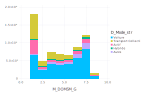

In [15]:
plot(train, x=:M_DOMSM_G, color=:D_Mode_str, Geom.histogram(bincount=9))

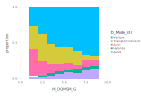

In [16]:
df = histnorm(train,0:1:9,:M_DOMSM_G)
plot(df, x = :M_DOMSM_G, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

Ce nouveau regroupement permet de constater une augmentation de l'utilisation de la voiture pour les régions plus éloignées de Montréal. Cette variable pourrait être intéressante pour intégrer le point de départ d'un individu dans notre modèle, mais nous sommes conscient que cette variable pourrait entraîner de la colinéarité avec d'autres variables comme la distance au centre-ville, par exemple.

### M_AUTO

Le nombre de voitures par ménage peut évidemment être une variable pertinente à notre modèle. Un ménage qui ne possède aucune voiture ne voyagera probablement pas en voiture alors qu'une persone d'un ménage avec plusieurs voitures pourrait potentiellement favoriser ce type de transport.

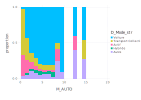

In [17]:
df = histnorm(train,0:1:19,:M_AUTO)
plot(df, x = :M_AUTO, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

Comme peu de ménages possède un grand nombre de voitures (la plupart en possède une ou deux), les données sur les modes de transport de ces ménages sont moins représentatives.

De plus, nous sommes d'avis que cette variable peut suivre une distribution de poisson. Il serait possiblement intéressant d'appliquer une transformation à cette variable pour en créer une nouvelle qui définie si un ménage possède au moins une voiture ou non. Cette nouvelle variable serait une bernoulli. Toutefois, nous pensons qu'une telle transformation entraînera une perte d'information. Nous verrons dans la section du maximum de vraisemblance si le modèle est meilleur lorsqu'il utilise la première variable ou la seconde.

### M_emploiTC

Le nombre d'emplois accessible en transport en commun en moins de 45 minutes à 8h le matin est une variable que l'on pourrait certainement utiliser afin d'améliorer la prédiction de l'utilisation du transport en commun. 

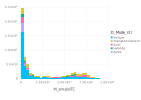

In [18]:
plot(train, x=:M_emploiTC, color=:D_Mode_str, Geom.histogram(bincount=30))

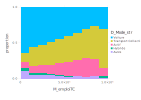

In [19]:
df = histnorm(train,0:1e5:1e6,:M_emploiTC)
plot(df, x = :M_emploiTC, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

Selon ce dernier diagramme, il apparaît évident que plus il y a d'emplois accessibles en moins de 45 minutes de transport en commun à 8h le matin, plus grandes sont les chances de choisir le transport en commmun. Nous posons également une autre observation suite à l'analyse de cette figure : le mode de transport actif croît aussi en fonction du nombre d'emplois.

// TODO: partagez-vous mon opinion sur cette remarque? Serait-il bien d'essayer de faire une combinaison de variables?
De plus, nous sommes d'avis que cette variable a beaucoup plus de valeur seulement lorsque la raison du déplacement est d'aller au travail. Une combinaison de cette variable ainsi que de D_MOTIF permettrait peut-être de limiter les fausses implications que cette variable entraînerait pour les autres motifs de déplacements. Toutefois, nous sommes conscients que cette variable peut également être un indicateur de l'accessibilité générale des transports en commun et n'est pas restreinte seulement aux déplacements 

## 3. Distributions selon le maximum de vraisemblance

À cette étape, on recherche les distributions appropriées pour chaque mode de transport pour chaque variable explicative étudiée. Le maximum de vraisemblance permet de trouver les paramètres des distributions. Avec le code suivant, nous sommes en mesure de tracer la distribution attendue sur la distribution réelle de l'échantillon. On peut changer les valeurs des trois premières variables pour tenter de trouver la bonne distribution à associer à une variable quelconque.

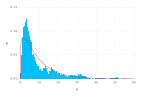

In [5]:
dep = 1;
sym = :M_dist_train
dist = Gamma

voi = train[train[:D_Mode] .== dep, :];
fd = fit_mle(dist, voi[sym]);
xx = 0:0.1:60;
f = pdf.(fd, xx);
h = layer(x = voi[sym], Geom.histogram(density = true));
f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
plot(f, h)

En combinant nos résultats dans l'étape de l'analyse exploratoire et nos connaissances en distributions, nous sommes parvenus aux distributions suivantes pour les variables explicatives utilisées dans le modèle.

### P_Permis

In [ ]:
# TODO

### M_dist_centre

In [ ]:
# TODO

### M_AUTO

In [ ]:
# TODO

### //TODO: ajouter des variables explicatives

## 4. Classification bayésienne naïve

## 5. Mix de variables